<img src = "https://upload.wikimedia.org/wikipedia/en/0/0f/Ola_Cabs_logo.svg">

<b>Problem Statement</b>

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

We have been provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error, f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("ola_driver_scaler.csv")

#### - Required functions

In [3]:
def print_dict(dict_, col_names, title = None):
    x = PrettyTable()

    x.field_names = col_names
    for keys in dict_.keys():
        if type(dict_[keys]) == list:
            x.add_row([keys] + dict_[keys])
        else:
            x.add_row([keys] + [dict_[keys]])

    if title:
        print(title)
    print(x)

def increased(x):
    return x.iloc[0] < x.astype(int).max()

IQR = lambda x : np.percentile(x, 75)-np.percentile(x, 25)

OUTLIER = lambda x, IQR  : (np.percentile(x, 25)-1.5*IQR, np.percentile(x, 75)+1.5*IQR)

def show_importance():
    plt.figure(figsize=(11, 10))
    plt.subplot(1,2,1)

    importance = rf_clf.feature_importances_
    abs_importance = [abs(i) for i in importance]
    top_ten_features = np.argsort(abs_importance)[:-11:-1][::-1]


    plt.barh(X_train.columns[top_ten_features], importance[top_ten_features])
    plt.yticks(rotation=45)
    plt.title('Feature Importance RandomForest')


    plt.subplot(1,2,2)
    xg_importance = clf.feature_importances_
    xg_abs_importance = [abs(i) for i in xg_importance]
    xg_top_ten_features = np.argsort(xg_abs_importance)[:-11:-1][::-1]


    plt.barh(X_train_OHE.columns[xg_top_ten_features], xg_importance[xg_top_ten_features])
    plt.yticks(rotation=45)
    plt.title('Feature Importance XGBoost')


    plt.show()

### - First look on the dataset

In [4]:
df.shape

(19104, 14)

In [5]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [6]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


- In the very first look it can be seen that there are some problems in data types of various features. We will look on that later.

In [7]:
df.iloc[0]

Unnamed: 0                     0
MMM-YY                  01/01/19
Driver_ID                      1
Age                         28.0
Gender                       0.0
City                         C23
Education_Level                2
Income                     57387
Dateofjoining           24/12/18
LastWorkingDate              NaN
Joining Designation            1
Grade                          1
Total Business Value     2381060
Quarterly Rating               2
Name: 0, dtype: object

### - Check for Duplicates

In [8]:
df.duplicated().sum()

0

### - .isnull()

In [9]:
print_dict({col:df[col].isnull().any() for col in df.columns},
           ['Columns', '.isnull()'],
           'Checking columns with null values')

Checking columns with null values
+----------------------+-----------+
|       Columns        | .isnull() |
+----------------------+-----------+
|      Unnamed: 0      |   False   |
|        MMM-YY        |   False   |
|      Driver_ID       |   False   |
|         Age          |    True   |
|        Gender        |    True   |
|         City         |   False   |
|   Education_Level    |   False   |
|        Income        |   False   |
|    Dateofjoining     |   False   |
|   LastWorkingDate    |    True   |
| Joining Designation  |   False   |
|        Grade         |   False   |
| Total Business Value |   False   |
|   Quarterly Rating   |   False   |
+----------------------+-----------+


- There are multiple columns with null values.
- Count of null values in each columns is needed to be checked which will be done later.

### - .info()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


### - Checking details of features and removing unnecessary features

- As already seen, there are null values in the dataset which needs treatment.
- Some of the features have ambiguous data type, which will be addressed later.

In [11]:
print_dict({col : [df[col].nunique(), df[col].dtype, df[col].isna().sum()] for col in df.columns},
           ["columns", ".nunique()", "dtype", "Null Values"])

+----------------------+------------+---------+-------------+
|       columns        | .nunique() |  dtype  | Null Values |
+----------------------+------------+---------+-------------+
|      Unnamed: 0      |   19104    |  int64  |      0      |
|        MMM-YY        |     24     |  object |      0      |
|      Driver_ID       |    2381    |  int64  |      0      |
|         Age          |     36     | float64 |      61     |
|        Gender        |     2      | float64 |      52     |
|         City         |     29     |  object |      0      |
|   Education_Level    |     3      |  int64  |      0      |
|        Income        |    2383    |  int64  |      0      |
|    Dateofjoining     |    869     |  object |      0      |
|   LastWorkingDate    |    493     |  object |    17488    |
| Joining Designation  |     5      |  int64  |      0      |
|        Grade         |     5      |  int64  |      0      |
| Total Business Value |   10181    |  int64  |      0      |
|   Quar

### - Univariate analysis and treating the features at the same time

#### - unnamed - 0

In [12]:
df = df.drop('Unnamed: 0', axis=1)

#### - MMM-YY

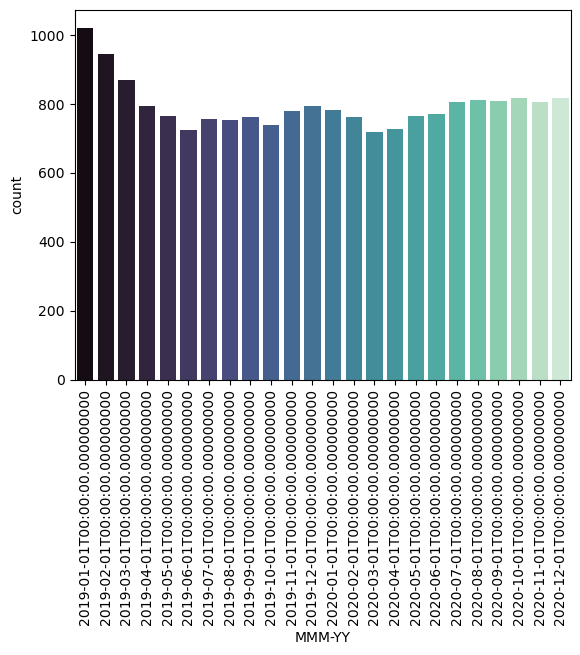

In [13]:
sns.countplot(pd.to_datetime(df['MMM-YY']).sort_values(), palette='mako')
plt.xticks(rotation=90)
plt.show()

- It can be seen that during first quater of 2019 the count of divers were the highest.
- There is some kind of trend in the data. The last quater and first quater seem to be the busiest months.

In [14]:
day = pd.to_datetime(df['MMM-YY']).apply(lambda x : x.day)

In [15]:
month = pd.to_datetime(df['MMM-YY']).apply(lambda x : x.month)

In [16]:
year = pd.to_datetime(df['MMM-YY']).apply(lambda x : x.year)

<AxesSubplot:xlabel='MMM-YY', ylabel='count'>

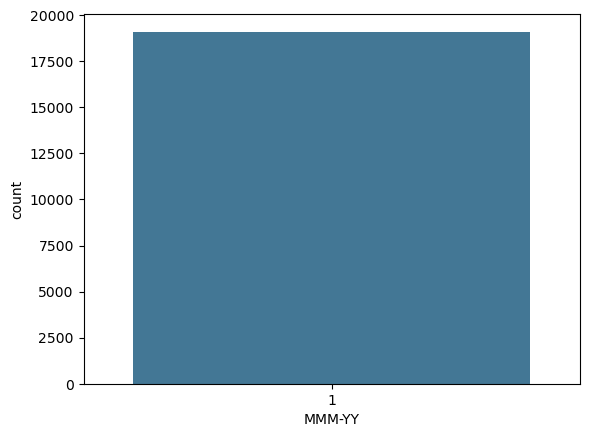

In [17]:
sns.countplot(day, palette="mako")

- Droping 'day' from MMM-YY as the value of day is always = 1.

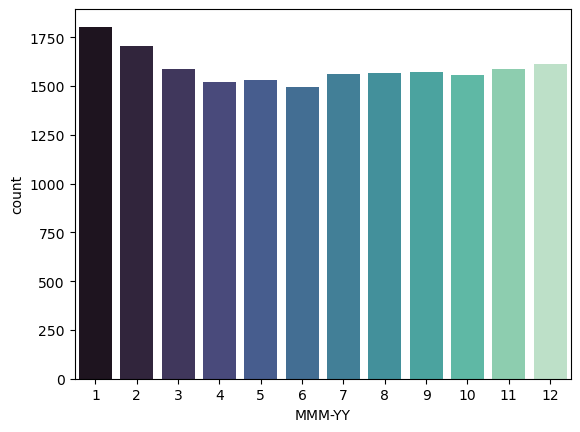

In [18]:
sns.countplot(month, palette="mako")
plt.show()

<AxesSubplot:xlabel='MMM-YY', ylabel='count'>

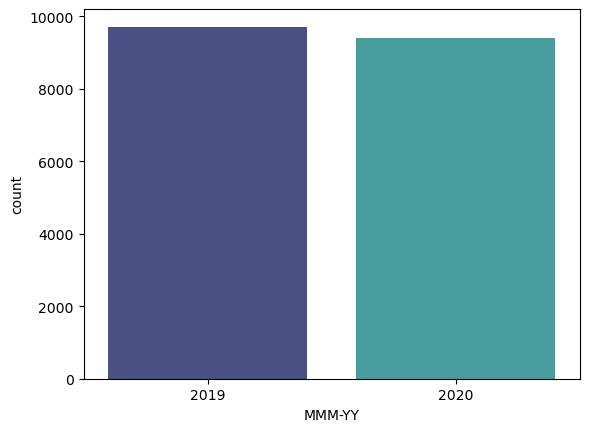

In [19]:
sns.countplot(year, palette="mako")

In [20]:
df = df.drop('MMM-YY', axis=1)

In [21]:
df['report_month'] = month.astype('category')

In [22]:
df['report_year'] = year.astype('category')

#### - Driver_ID

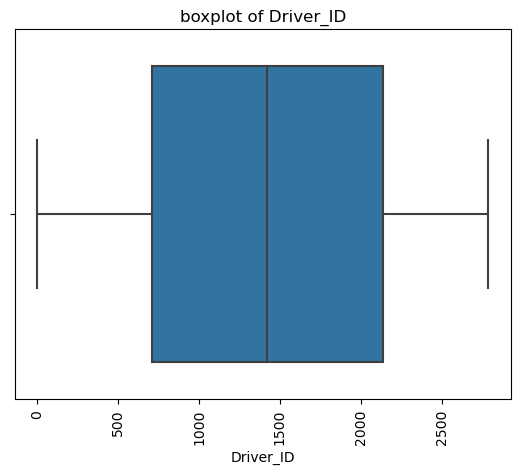

min :  1 
max :  2788


In [23]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1,2,1)
# sns.histplot(df.Driver_ID)
# plt.title('distplot of Driver_ID')
# plt.subplot(1,2,2)
sns.boxplot(df.Driver_ID)
plt.title('boxplot of Driver_ID')
plt.xticks(rotation=90)
plt.show()

print('min : ', df.Driver_ID.min(),'\nmax : ', df.Driver_ID.max())
plt.show()

#### - Age

In [24]:
df.Age.dtype

dtype('float64')

In [25]:
sum(df.Age.isnull())

61

- Ideally, we want Age to be integer but there are 64 null values in the feature and 'nan' type can only be available in float. This will be done after KNN inputaion is done.

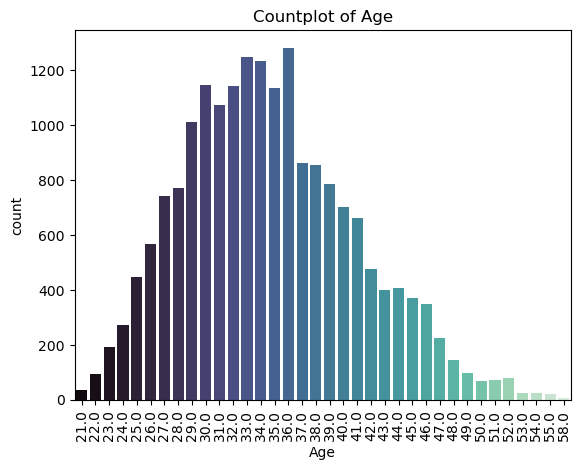

In [26]:
sns.countplot(df.Age, palette='mako')
plt.xticks(rotation=90)
plt.title('Countplot of Age')
plt.show()

#### - Gender

In [27]:
df.Gender.dtype

dtype('float64')

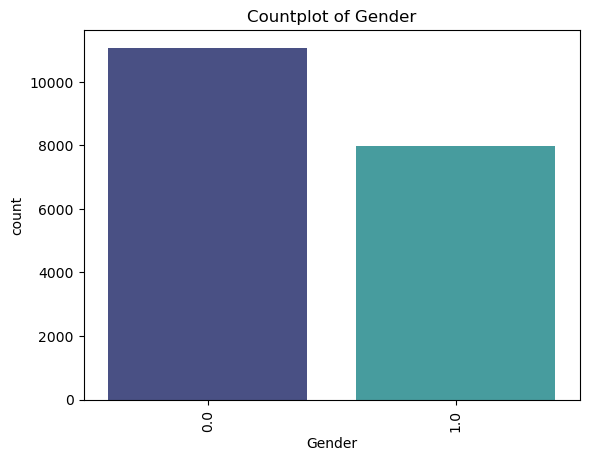

In [28]:
sns.countplot(df.Gender, palette='mako')
plt.xticks(rotation=90)
plt.title('Countplot of Gender')
plt.show()

In [29]:
df.Gender.value_counts()

0.0    11074
1.0     7978
Name: Gender, dtype: int64

In [30]:
sum(df.Gender.isnull())

52

- Same as feature 'Age', 'Gender' also has 52 null fearures and will be treated the same way.

#### - City

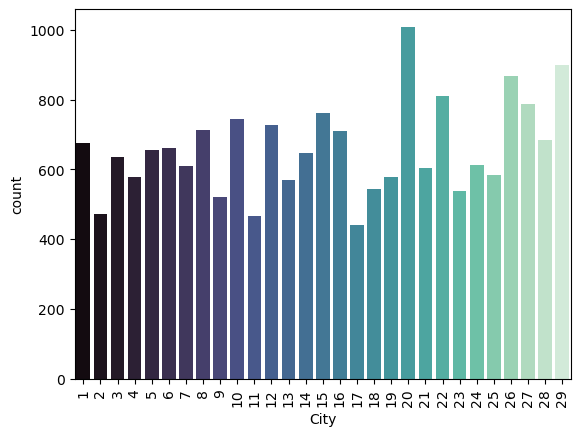

In [31]:
sns.countplot(df.City.apply(lambda x : x[1:]).astype(int), palette='mako', )
plt.xticks(rotation = 90)
plt.show()

In [32]:
df.City = df.City.apply(lambda x : x[1:])
df.City = df.City.astype('category')

In [33]:
df

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,report_month,report_year
0,1,28.0,0.0,23,2,57387,24/12/18,NaN,1,1,2381060,2,1,2019
1,1,28.0,0.0,23,2,57387,24/12/18,NaN,1,1,-665480,2,2,2019
2,1,28.0,0.0,23,2,57387,24/12/18,03/11/19,1,1,0,2,3,2019
3,2,31.0,0.0,7,2,67016,11/06/20,NaN,2,2,0,1,11,2020
4,2,31.0,0.0,7,2,67016,11/06/20,NaN,2,2,0,1,12,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2788,30.0,0.0,27,2,70254,06/08/20,NaN,2,2,740280,3,8,2020
19100,2788,30.0,0.0,27,2,70254,06/08/20,NaN,2,2,448370,3,9,2020
19101,2788,30.0,0.0,27,2,70254,06/08/20,NaN,2,2,0,2,10,2020
19102,2788,30.0,0.0,27,2,70254,06/08/20,NaN,2,2,200420,2,11,2020


In [34]:
df.columns

Index(['Driver_ID', 'Age', 'Gender', 'City', 'Education_Level', 'Income',
       'Dateofjoining', 'LastWorkingDate', 'Joining Designation', 'Grade',
       'Total Business Value', 'Quarterly Rating', 'report_month',
       'report_year'],
      dtype='object')

#### - Education_Level

In [35]:
df.Education_Level.value_counts()

1    6864
2    6327
0    5913
Name: Education_Level, dtype: int64

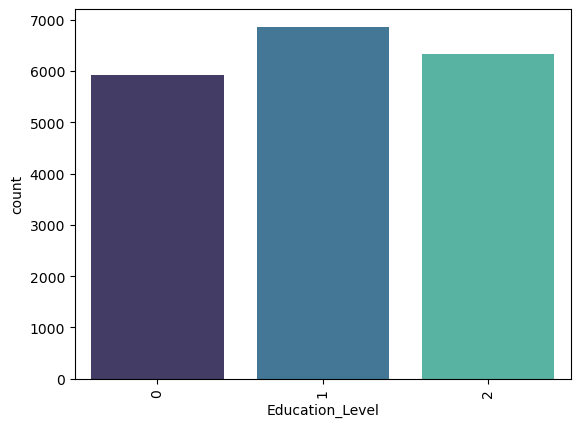

In [36]:
sns.countplot(df.Education_Level, palette='mako', )
plt.xticks(rotation = 90)
plt.show()

In [37]:
df.Education_Level = df.Education_Level.astype('category')

#### - Income

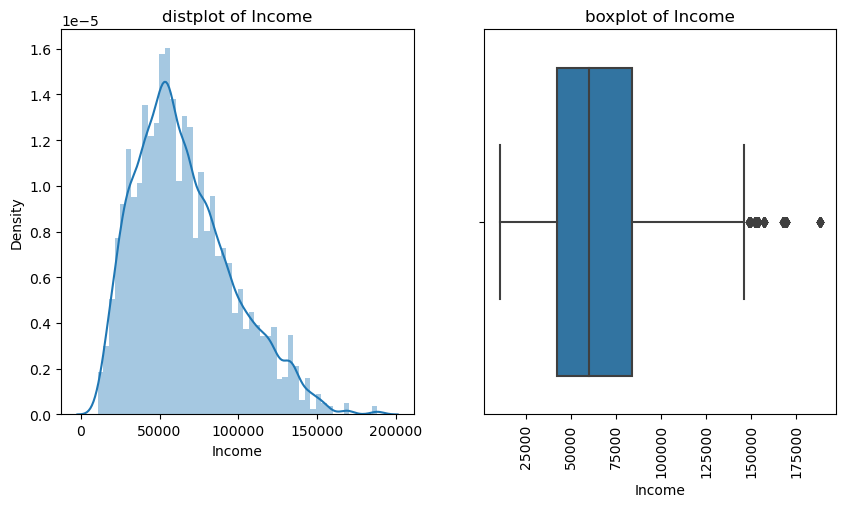

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sns.distplot(df.Income)
plt.title('distplot of Income')
plt.subplot(1,2,2)
sns.boxplot(df.Income)
plt.title('boxplot of Income')
plt.xticks(rotation=90)
plt.show()

- It seems like there are some outliers but it should be fine because income data is usualy skewed.

#### - Dateofjoining

In [39]:
df.Dateofjoining.min()

'01/01/18'

In [40]:
df.Dateofjoining.max()

'31/12/18'

In [41]:
temp = pd.to_datetime(df.Dateofjoining)

In [42]:
temp.min()

Timestamp('2013-04-01 00:00:00')

In [43]:
temp[0]

Timestamp('2018-12-24 00:00:00')

In [44]:
day = pd.to_datetime(df.Dateofjoining).apply(lambda x : x.day)

In [45]:
month = pd.to_datetime(df.Dateofjoining).apply(lambda x : x.month)

In [46]:
year = pd.to_datetime(df.Dateofjoining).apply(lambda x : x.year)

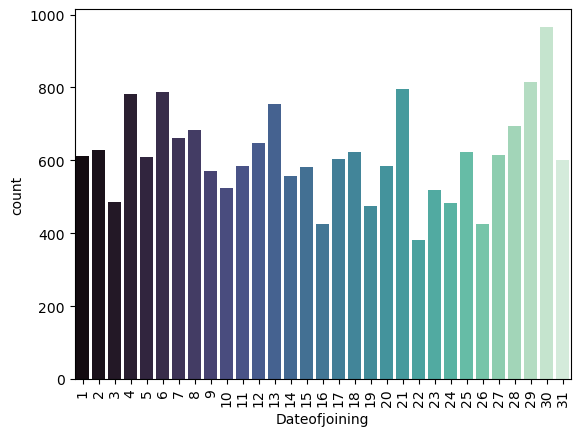

In [47]:
sns.countplot(day, palette="mako")
plt.xticks(rotation=90)
plt.show()

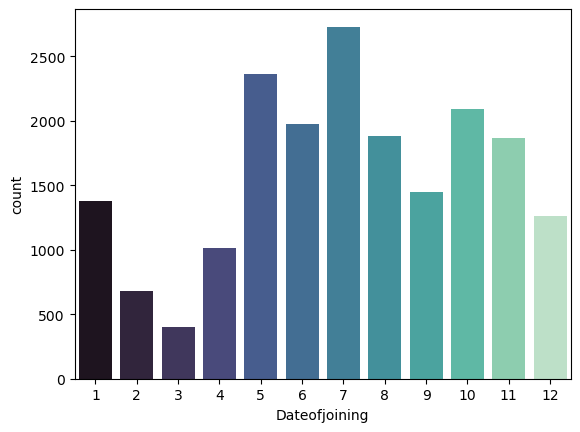

In [48]:
sns.countplot(month, palette="mako")
plt.show()

<AxesSubplot:xlabel='Dateofjoining', ylabel='count'>

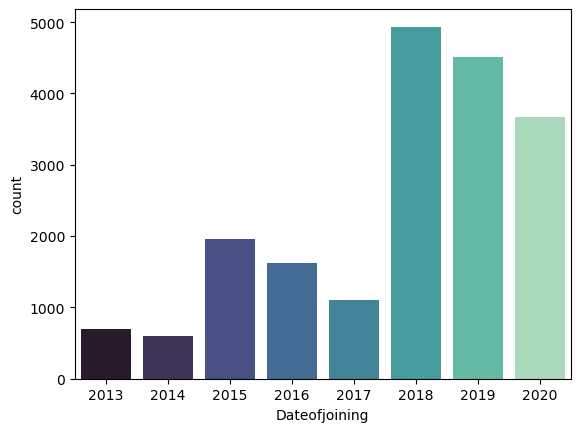

In [49]:
sns.countplot(year, palette="mako")

In [50]:
df = df.drop('Dateofjoining', axis=1)

In [51]:
df['joining_day'] = month.astype('category')

In [52]:
df['joining_month'] = month.astype('category')

In [53]:
df['joining_year'] = year.astype('category')

#### - LastWorkingDate

In [54]:
df.LastWorkingDate

0             NaN
1             NaN
2        03/11/19
3             NaN
4             NaN
           ...   
19099         NaN
19100         NaN
19101         NaN
19102         NaN
19103         NaN
Name: LastWorkingDate, Length: 19104, dtype: object

In [55]:
df.LastWorkingDate[df.LastWorkingDate.isnull()==False] = 1

In [56]:
df.LastWorkingDate[df.LastWorkingDate.isnull()] = 0

In [57]:
df['target'] = df.LastWorkingDate.astype('category')

In [58]:
df = df.drop('LastWorkingDate', axis=1)

In [59]:
df.target.value_counts()

0    17488
1     1616
Name: target, dtype: int64

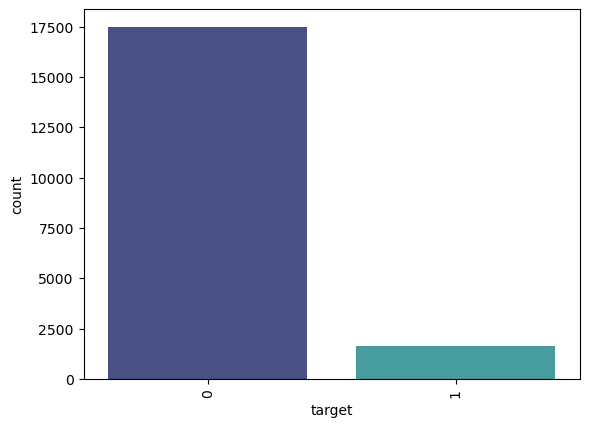

In [60]:
sns.countplot(df.target, palette='mako', )
plt.xticks(rotation = 90)
plt.show()

#### - Joining Designation

In [61]:
df['Joining Designation'] = df['Joining Designation'].astype('category')

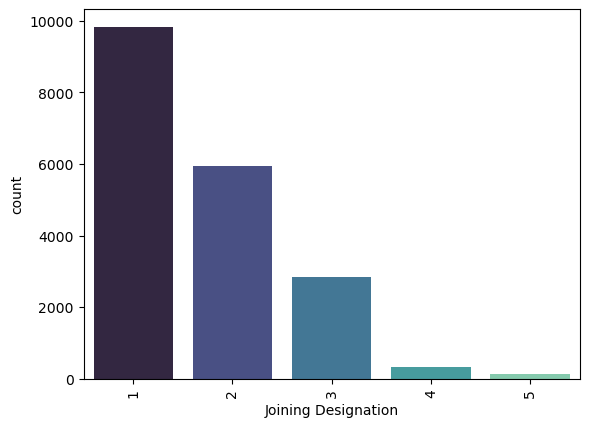

In [62]:
sns.countplot(df['Joining Designation'], palette='mako', )
plt.xticks(rotation = 90)
plt.show()

- Most of the drivers have lower designation at the time of joining

#### - Grade

In [63]:
df['Grade'] = df['Grade'].astype('category')

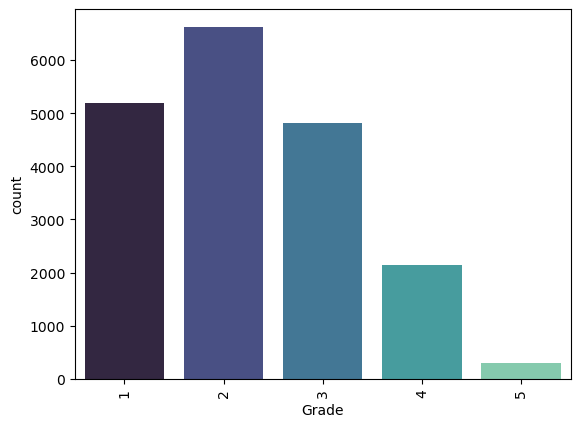

In [64]:
sns.countplot(df.Grade, palette='mako', )
plt.xticks(rotation = 90)
plt.show()

#### - Quarterly Rating

In [65]:
df['Quarterly Rating'] = df['Quarterly Rating'].astype('category')

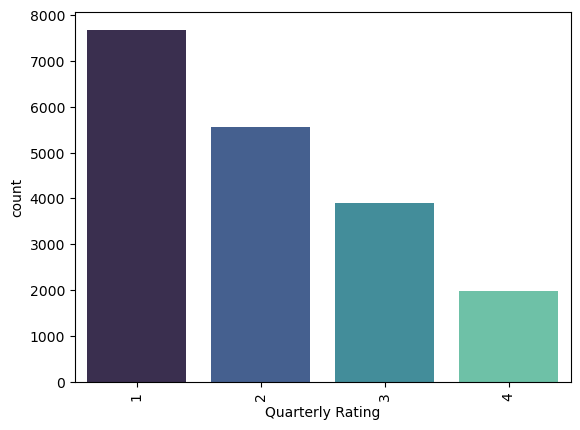

In [66]:
sns.countplot(df['Quarterly Rating'], palette='mako', )
plt.xticks(rotation = 90)
plt.show()

#### - Total Business Value

In [67]:
df['Total Business Value'].shape

(19104,)

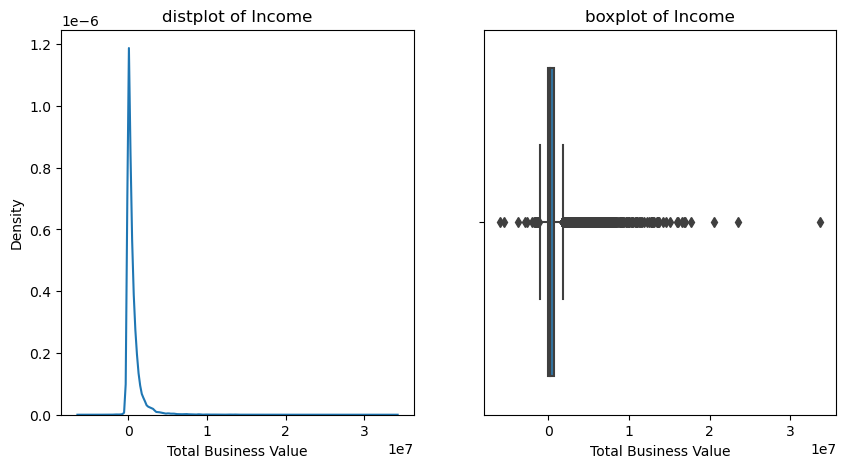

min -6000000 max :  33747720


In [68]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sns.kdeplot(df['Total Business Value'])
plt.title('distplot of Income')
plt.subplot(1,2,2)
sns.boxplot(df['Total Business Value'])
plt.title('boxplot of Income')
plt.show()

print('min', df['Total Business Value'].min(), 'max : ', df['Total Business Value'].max())


##### - Outlier treatmeant using IQR method

In [69]:
sum(df['Total Business Value']>10000000)

40

- There are some outlier in 'Total Business Value'. There are about 40 points where the monthly Total Business Value is greater than 10 Million(This is a very huge number).
- Lets use IQR method to treat the outliers.

In [70]:
iqr_tot_buisness_val = IQR(df['Total Business Value'])
print(iqr_tot_buisness_val)

699700.0


In [71]:
range_tot_buisness_val = OUTLIER(df['Total Business Value'], iqr_tot_buisness_val)

- ( Q1-1.5\*IQR , Q3+1.5\*IQR ) 

In [72]:
range_tot_buisness_val

(-1049550.0, 1749250.0)

In [73]:
sum(df['Total Business Value']<range_tot_buisness_val[0])

16

In [74]:
sum(df['Total Business Value']>range_tot_buisness_val[1])

1355

In [75]:
outliers = np.logical_or(
    df['Total Business Value']<range_tot_buisness_val[0],
    df['Total Business Value']>range_tot_buisness_val[1])
print('Outlier Count : ', sum(outliers), 'Percentage : ', round(sum(outliers)/df.shape[0]*100, 2))

Outlier Count :  1371 Percentage :  7.18


- It is fine to remove ~7% of data points.

In [76]:
df.shape

(19104, 16)

In [77]:
df = df.drop(outliers[outliers==True].index)

In [78]:
df.shape

(17733, 16)

#### - Imputing the missing values using KNNImputer

In [79]:
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(df.drop(['City', 'target'], axis=1))

In [80]:
df.Age = imputed_values[:, 1]

In [81]:
df.Age = df.Age.astype('int')#.astype('category')

In [82]:
df.Gender = imputed_values[:, 2]

In [83]:
df.Gender = df.Gender.astype('int').astype('category')

### - Grouing the data by Driver_ID

In [84]:
df = df.drop(['report_month', 'report_year'], axis=1)

- report_month and report_year does not make sense if we group the features by Driver_ID

In [85]:
agg_dict = {'Age' : 'first',
            'Gender' : 'first',
            'City' : 'first',
            'Education_Level' : 'first',
            'Income' : ['first', increased],
            'Joining Designation' :  'first',
            'Grade': ['first', increased],
            'Total Business Value' : 'sum',
            'Quarterly Rating': ['first', increased],
            'joining_day' : 'first',
            'joining_month' : 'first',
            'joining_year' : 'first',
            'target' : 'last'}

In [86]:
agg_df = df.groupby('Driver_ID')

In [87]:
agg_df = agg_df.aggregate(agg_dict)

In [88]:
agg_df.columns

MultiIndex([(                 'Age',     'first'),
            (              'Gender',     'first'),
            (                'City',     'first'),
            (     'Education_Level',     'first'),
            (              'Income',     'first'),
            (              'Income', 'increased'),
            ( 'Joining Designation',     'first'),
            (               'Grade',     'first'),
            (               'Grade', 'increased'),
            ('Total Business Value',       'sum'),
            (    'Quarterly Rating',     'first'),
            (    'Quarterly Rating', 'increased'),
            (         'joining_day',     'first'),
            (       'joining_month',     'first'),
            (        'joining_year',     'first'),
            (              'target',      'last')],
           )

In [89]:
final_df = pd.DataFrame()

In [90]:
for multilevel_col in agg_df.columns:
    if multilevel_col[1] == 'increased':
        final_df[multilevel_col[0]+'_'+multilevel_col[1]] = agg_df[multilevel_col]
    else:
        final_df[multilevel_col[0]] = agg_df[multilevel_col]

In [91]:
final_df

,Age,Gender,City,Education_Level,Income,Income_increased,Joining Designation,Grade,Grade_increased,Total Business Value,Quarterly Rating,Quarterly Rating_increased,joining_day,joining_month,joining_year,target
Driver_ID,,,,,,,,,,,,,,,,
1,28,0,23,2,57387,False,1,1,False,-665480,2,False,12,12,2018,1
2,31,0,7,2,67016,False,2,2,False,0,1,False,11,11,2020,0
4,43,0,13,2,65603,False,2,2,False,350000,1,False,12,12,2019,1
5,29,0,9,0,46368,False,1,1,False,120360,1,False,1,1,2019,1
6,31,1,11,1,78728,False,3,3,False,1265000,1,True,7,7,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,33,0,24,0,82815,False,2,3,False,10037490,3,True,10,10,2015,0
2785,34,1,9,0,12105,False,1,1,False,0,1,False,8,8,2020,1
2786,44,0,19,0,35370,False,2,2,False,2815090,2,False,7,7,2018,1


In [92]:
sum(final_df.Income_increased)

43

In [93]:
final_df

,Age,Gender,City,Education_Level,Income,Income_increased,Joining Designation,Grade,Grade_increased,Total Business Value,Quarterly Rating,Quarterly Rating_increased,joining_day,joining_month,joining_year,target
Driver_ID,,,,,,,,,,,,,,,,
1,28,0,23,2,57387,False,1,1,False,-665480,2,False,12,12,2018,1
2,31,0,7,2,67016,False,2,2,False,0,1,False,11,11,2020,0
4,43,0,13,2,65603,False,2,2,False,350000,1,False,12,12,2019,1
5,29,0,9,0,46368,False,1,1,False,120360,1,False,1,1,2019,1
6,31,1,11,1,78728,False,3,3,False,1265000,1,True,7,7,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,33,0,24,0,82815,False,2,3,False,10037490,3,True,10,10,2015,0
2785,34,1,9,0,12105,False,1,1,False,0,1,False,8,8,2020,1
2786,44,0,19,0,35370,False,2,2,False,2815090,2,False,7,7,2018,1


In [94]:
final_df.Income_increased = final_df.Income_increased*1

In [95]:
final_df['Quarterly Rating_increased'] = final_df['Quarterly Rating_increased']*1

In [96]:
final_df.Grade_increased= final_df.Grade_increased*1

In [97]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 1 to 2788
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Age                         2381 non-null   int32   
 1   Gender                      2381 non-null   category
 2   City                        2381 non-null   category
 3   Education_Level             2381 non-null   category
 4   Income                      2381 non-null   int64   
 5   Income_increased            2381 non-null   int32   
 6   Joining Designation         2381 non-null   category
 7   Grade                       2381 non-null   category
 8   Grade_increased             2381 non-null   int32   
 9   Total Business Value        2381 non-null   int64   
 10  Quarterly Rating            2381 non-null   category
 11  Quarterly Rating_increased  2381 non-null   int32   
 12  joining_day                 2381 non-null   category
 13  joining_month     

### - Pearson Correlation

In [98]:
final_df

,Age,Gender,City,Education_Level,Income,Income_increased,Joining Designation,Grade,Grade_increased,Total Business Value,Quarterly Rating,Quarterly Rating_increased,joining_day,joining_month,joining_year,target
Driver_ID,,,,,,,,,,,,,,,,
1,28,0,23,2,57387,0,1,1,0,-665480,2,0,12,12,2018,1
2,31,0,7,2,67016,0,2,2,0,0,1,0,11,11,2020,0
4,43,0,13,2,65603,0,2,2,0,350000,1,0,12,12,2019,1
5,29,0,9,0,46368,0,1,1,0,120360,1,0,1,1,2019,1
6,31,1,11,1,78728,0,3,3,0,1265000,1,1,7,7,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,33,0,24,0,82815,0,2,3,0,10037490,3,1,10,10,2015,0
2785,34,1,9,0,12105,0,1,1,0,0,1,0,8,8,2020,1
2786,44,0,19,0,35370,0,2,2,0,2815090,2,0,7,7,2018,1


In [99]:
num_temp = final_df.drop('City', axis=1).astype('float')

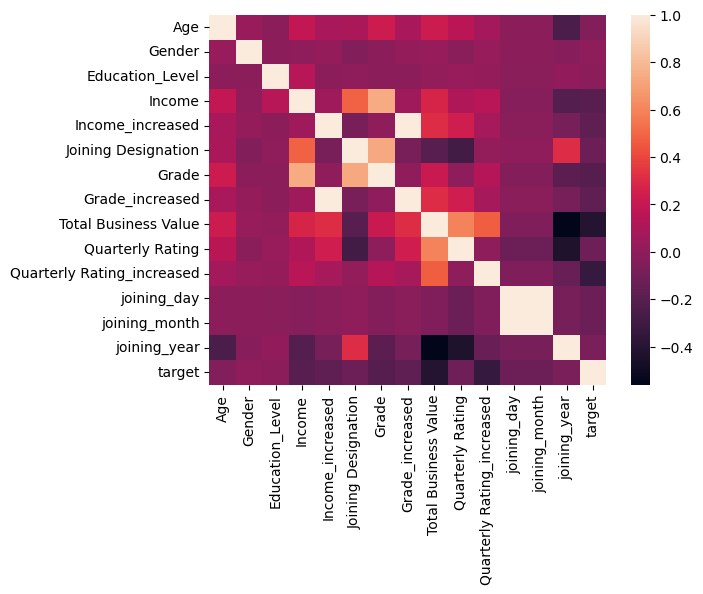

In [100]:
num_corr = num_temp.corr()
sns.heatmap(num_corr)
plt.show()

In [101]:
corr_dict = {}
for row in num_corr.columns:
    for col in num_corr.columns:
        if abs(num_corr[row][col]) > .5 and num_corr[row][col]!=1:
            corr_dict[tuple(set((row, col)))] = num_corr[row][col]

In [102]:
print_dict(corr_dict, ['col', 'corr'], 'List of features having corr>.5', )

List of features having corr>.5
+----------------------------------------------+---------------------+
|                     col                      |         corr        |
+----------------------------------------------+---------------------+
|             ('Income', 'Grade')              |  0.7383776746394687 |
|       ('Grade', 'Joining Designation')       |  0.7322039417292144 |
| ('Quarterly Rating', 'Total Business Value') |  0.5971251136838736 |
|   ('joining_year', 'Total Business Value')   | -0.5601807406951896 |
+----------------------------------------------+---------------------+


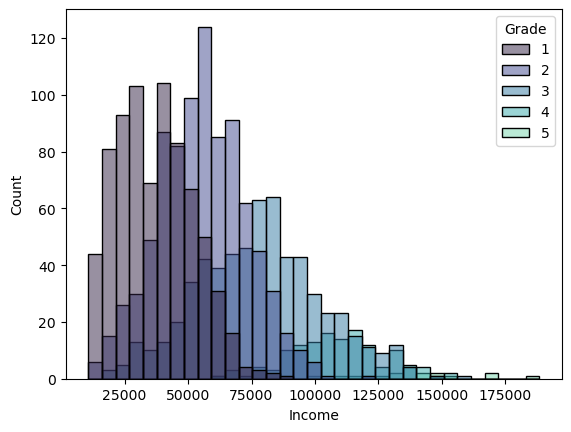

In [103]:
sns.histplot(data=final_df, x='Income', hue='Grade', palette='mako')
plt.show()

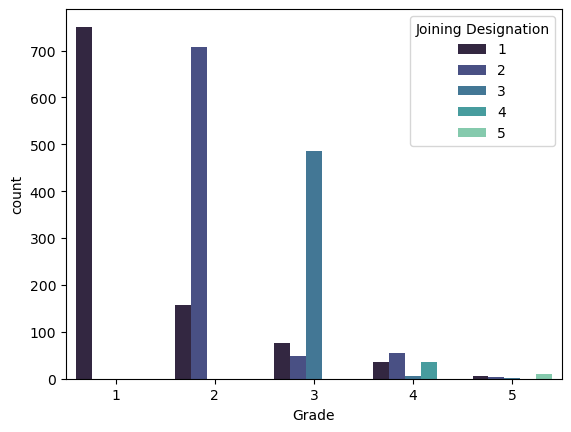

In [104]:
sns.countplot(data=final_df, x='Grade', hue='Joining Designation', palette='mako')
plt.show()

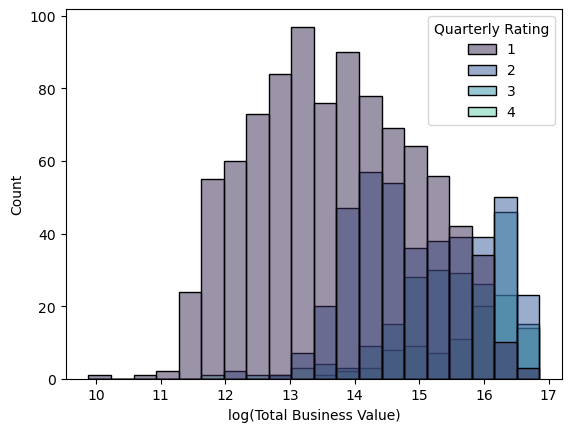

In [105]:
sns.histplot(x=np.log(final_df['Total Business Value']), hue=final_df['Quarterly Rating'], palette='mako')
plt.xlabel('log(Total Business Value)')
plt.show()

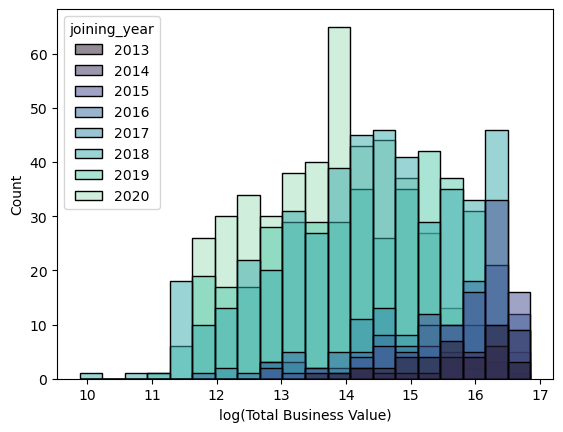

In [106]:
sns.histplot(x=np.log(final_df['Total Business Value']), hue=final_df['joining_year'], palette='mako')
plt.xlabel('log(Total Business Value)')
plt.show()

### - Standardization

- Standardization is not required in tree based algorithms such as Decision Tree and Random Forest.
- Not doing standization also helps in interpretability to a certain extent.
- Standardization is important when the algorithm is linear or distance based.
- One one hand, XGBoost is a tree based algorithm is tree base. But on the other hand, XGBoost use linear boosting for colaboration which is sensitive to scaling.
- XGBoost sacrifices interpretablility for better performance.

<b>NOTE :</b> Study and prove related to this can be found on this links.<br>
- https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalize-data-for-xgboost<br>
- https://github.com/dmlc/xgboost/issues/357
- https://stats.stackexchange.com/questions/485677/does-xgboost-require-standarized-data

### - One Hot encoding

- This is again a similar situtation as the previous one. 
- Decision tree does not need the categorical features to be encoding using One Hot Encoding, integer encoding is enough for tree based models.
- This helps the tree base molel to be one of the most interpretable and best algorithm for decision making.
- First of all XGBoost is on a black box side. This models is so complex that it sometimes goes beyond humans understanding to comprehend each decision.
-And, some studies shows that boosting algorithms such as XGBoost benifits from One Hot Encoding.

<b>NOTE :</b> Study and prove related to this can be found on this links.<br>
- https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-One-Hot-Encoding-Improves-Machine-Learning-Performance--VmlldzoxOTkzMDk#:~:text=However%2C%20this%20is%20not%20true,variables%20without%20one%2Dhot%20encoding.
- https://discuss.analyticsvidhya.com/t/advantages-of-one-hot-coding-for-gbm-or-xgboost/7570

<b>Requirements :</b>
- In this case study, it would be better to have some kind of interpretability that may help to understand the buisness better.
- But we also want the model to perform the best possible.

<b>Solution : </b>
- Having two data set one with standardization and OHE for the Boosting Model(XGBOOST) and another without standardization and OHE for the Bagging Model(Random Forest).
- Random Forest may not be as powerful as XGBoost but it provides the interpretability that we need to get insignts and get some decisions.

### - Class Imbalance Treatmeant

- There are was to tackle imbalanced data like oversampling.
- Some study have also shown that imbalanced data can be handled by ensemble models by deafauls.
- On top if that RamdomForest and XGBoost can deal with imbalanced data using class weights.
- Hence, It seems like there is no need to use oversampling to deal with the imbalanced data.

In [107]:
final_df.reset_index(inplace=True)

In [108]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Driver_ID                   2381 non-null   int64   
 1   Age                         2381 non-null   int32   
 2   Gender                      2381 non-null   category
 3   City                        2381 non-null   category
 4   Education_Level             2381 non-null   category
 5   Income                      2381 non-null   int64   
 6   Income_increased            2381 non-null   int32   
 7   Joining Designation         2381 non-null   category
 8   Grade                       2381 non-null   category
 9   Grade_increased             2381 non-null   int32   
 10  Total Business Value        2381 non-null   int64   
 11  Quarterly Rating            2381 non-null   category
 12  Quarterly Rating_increased  2381 non-null   int32   
 13  joining_day       

### - Training RandomForest

In [109]:
X, y = final_df.drop('target', axis=1), final_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)
print('Train Shape : ', X_train.shape, 'Test Shape : ', X_test.shape)

Train Shape :  (1904, 16) Test Shape :  (477, 16)


In [110]:
rf_clf = RandomForestClassifier(max_depth=5, n_estimators=150, class_weight='balanced')
rf_clf = rf_clf.fit(X_train, y_train)

In [111]:
y_test_pred = rf_clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
test_rf = {'auc': round(auc(fpr, tpr), 2),
            'accuracy' : round(accuracy_score(y_test, y_test_pred), 2),
            'macro_f1' : round(f1_score(y_test, y_test_pred, average='macro'), 2)
           }

In [112]:
y_train_pred = rf_clf.predict(X_train)
t_fpr, t_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
train_rf = {'auc': round(auc(t_fpr, t_tpr), 2),
            'accuracy' : round(accuracy_score(y_train, y_train_pred), 2),
            'macro_f1' : round(f1_score(y_train, y_train_pred, average='macro'), 2)
           }

In [113]:
print('Test AUC Score :', test_rf['auc'])
print('Test Accuracy :', test_rf['accuracy'])

Test AUC Score : 0.96
Test Accuracy : 0.89


In [114]:
print('Train AUC Score :', train_rf['auc'])
print('Train Accuracy :', train_rf['accuracy'])

Train AUC Score : 0.96
Train Accuracy : 0.89


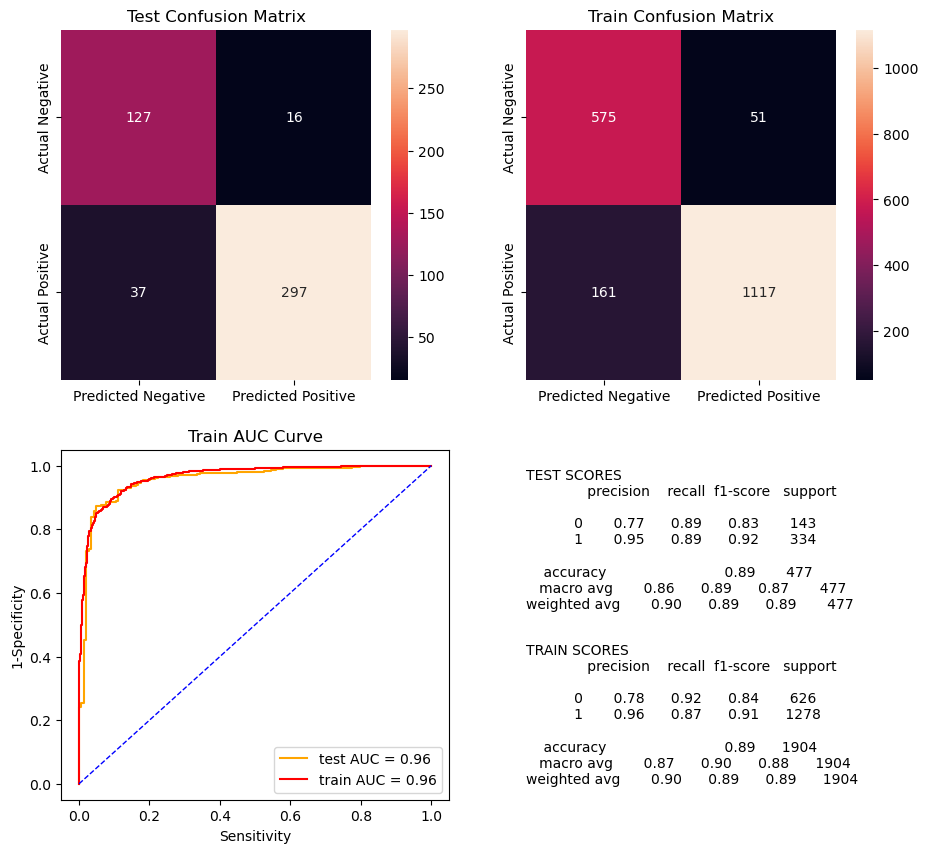

In [115]:
plt.figure(figsize=(11, 10))
plt.subplot(2,2,1)
con_matrix  = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                           index = ('Actual Negative', 'Actual Positive'),
                           columns = ('Predicted Negative', 'Predicted Positive'))
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.title('Test Confusion Matrix')

plt.subplot(2,2,2)
con_matrix  = pd.DataFrame(confusion_matrix(y_train, y_train_pred),
                           index = ('Actual Negative', 'Actual Positive'),
                           columns = ('Predicted Negative', 'Predicted Positive'))
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.title('Train Confusion Matrix')

plt.subplot(2,2,3)
plt.plot(fpr, tpr, label="test AUC = "+ str(test_rf['auc']), color='orange')
plt.plot(t_fpr, t_tpr, label="train AUC = "+ str(train_rf['auc']), color = 'red')
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
plt.legend()
plt.xlabel("Sensitivity")
plt.ylabel("1-Specificity")
plt.title("Train AUC Curve")

plt.subplot(2,2,4)
plt.text(0.0, 0.5, 'TEST SCORES\n'+classification_report(y_test, y_test_pred))
plt.text(0.0, 0, 'TRAIN SCORES\n'+classification_report(y_train, y_train_pred))

plt.axis('off')

plt.show()

### - Training XGBoost

In [116]:
X, y = final_df.drop('target', axis=1), final_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)
print('Train Shape : ', X_train.shape, 'Test Shape : ', X_test.shape)

Train Shape :  (1904, 16) Test Shape :  (477, 16)


##### - One Hot Encoding

In [117]:
X_train.columns[X_train.dtypes=='category']

Index(['Gender', 'City', 'Education_Level', 'Joining Designation', 'Grade',
       'Quarterly Rating', 'joining_day', 'joining_month', 'joining_year'],
      dtype='object')

- 'Gender' : There 2 classes in gender so there is not need to encode.
- 'Education_Level', 'Joining Designation' , 'Grade', 'Quarterly Rating', 'joining_day', 'joining_month', 'joining_year' : This features should not be encoded. Values of this fearures have meaning to it. Encoding this features will cause loss of information.
- 'City' : Can be encoded with One Hot Encoder.

In [118]:
City_train = pd.get_dummies(X_train.City, drop_first=True)
X_train_OHE = pd.DataFrame()
X_train_OHE = pd.concat([X_train, City_train], axis=1)
X_train_OHE = X_train_OHE.drop("City", axis=1)

City_test = pd.get_dummies(X_test.City, drop_first=True)
X_test_OHE = pd.DataFrame()
X_test_OHE = pd.concat([X_test, City_test], axis=1)
X_test_OHE = X_test_OHE.drop("City", axis=1)
print('Train Shape : ', X_train_OHE.shape, 'Test Shape : ', X_test_OHE.shape)

Train Shape :  (1904, 43) Test Shape :  (477, 43)


##### - Standardization

In [119]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_OHE)
X_test_scaled = scaler.transform(X_test_OHE)

In [120]:
clf = XGBClassifier(n_estimators=200, max_depth=2)
clf = clf.fit(X_train_scaled, y_train)

In [132]:
y_test_pred = clf.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_scaled)[:,1])
test_xgb = {'auc': round(auc(fpr, tpr), 2),
            'accuracy' : round(accuracy_score(y_test, y_test_pred), 2),
            'macro_f1' : round(f1_score(y_test, y_test_pred, average='macro'), 2)
           }

In [133]:
y_train_pred = clf.predict(X_train_scaled)
t_fpr, t_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_scaled)[:,1])
train_xgb = {'auc': round(auc(t_fpr, t_tpr), 2),
            'accuracy' : round(accuracy_score(y_train, y_train_pred), 2),
            'macro_f1' : round(f1_score(y_train, y_train_pred, average='macro'), 2)
           }

In [135]:
print('Test AUC Score :', test_xgb['auc'])
print('Test Accuracy :', test_xgb['accuracy'])

Test AUC Score : 0.95
Test Accuracy : 0.88


In [136]:
print('Train AUC Score :', train_xgb['auc'])
print('Train Accuracy :', train_xgb['accuracy'])

Train AUC Score : 0.99
Train Accuracy : 0.96


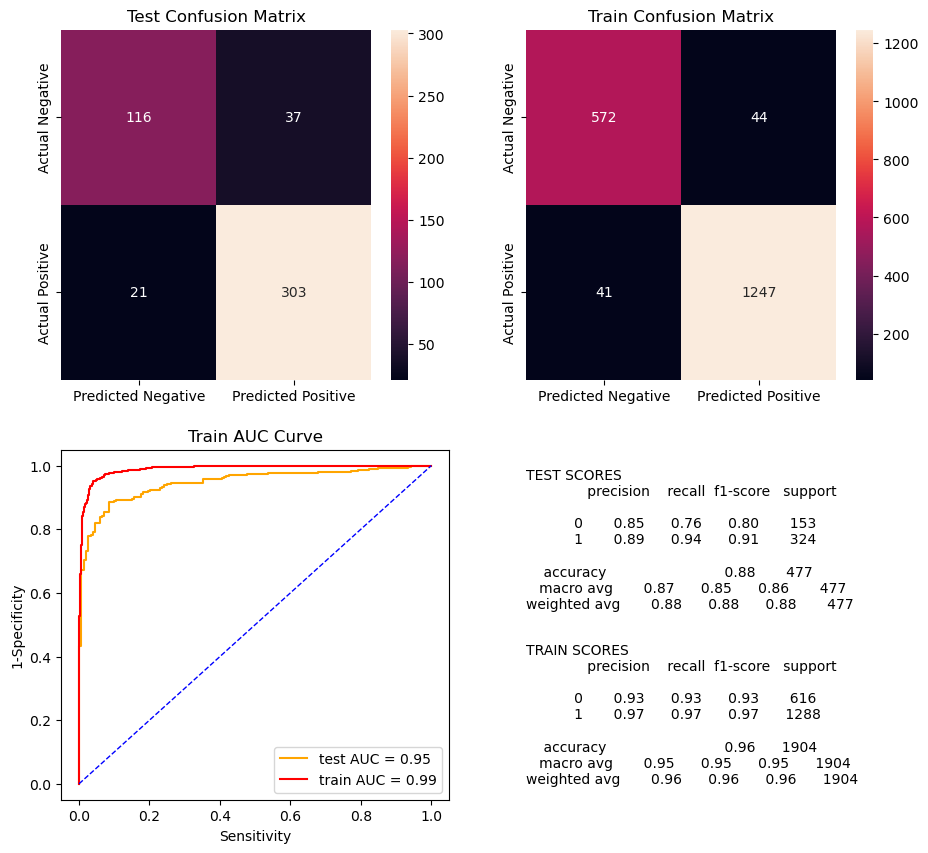

In [137]:
plt.figure(figsize=(11, 10))
plt.subplot(2,2,1)
con_matrix  = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                           index = ('Actual Negative', 'Actual Positive'),
                           columns = ('Predicted Negative', 'Predicted Positive'))
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.title('Test Confusion Matrix')

plt.subplot(2,2,2)
con_matrix  = pd.DataFrame(confusion_matrix(y_train, y_train_pred),
                           index = ('Actual Negative', 'Actual Positive'),
                           columns = ('Predicted Negative', 'Predicted Positive'))
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.title('Train Confusion Matrix')

plt.subplot(2,2,3)
plt.plot(fpr, tpr, label="test AUC = "+ str(test_xgb['auc']), color='orange')
plt.plot(t_fpr, t_tpr, label="train AUC = "+ str(train_xgb['auc']), color = 'red')
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
plt.legend()
plt.xlabel("Sensitivity")
plt.ylabel("1-Specificity")
plt.title("Train AUC Curve")

plt.subplot(2,2,4)
plt.text(0.0, 0.5, 'TEST SCORES\n'+classification_report(y_test, y_test_pred))
plt.text(0.0, 0, 'TRAIN SCORES\n'+classification_report(y_train, y_train_pred))

plt.axis('off')

plt.show()

## - Insignts

#### - Scores

In [138]:
print_dict(train_rf, ['Metric', 'Scores'], 'Train Scores of RandomForest')

Train Scores of RandomForest
+----------+--------+
|  Metric  | Scores |
+----------+--------+
|   auc    |  0.96  |
| accuracy |  0.89  |
| macro_f1 |  0.88  |
+----------+--------+


In [139]:
print_dict(test_rf, ['Metric', 'Scores'])

+----------+--------+
|  Metric  | Scores |
+----------+--------+
|   auc    |  0.96  |
| accuracy |  0.89  |
| macro_f1 |  0.87  |
+----------+--------+


In [141]:
print_dict(train_xgb, ['Metric', 'Scores'])

+----------+--------+
|  Metric  | Scores |
+----------+--------+
|   auc    |  0.99  |
| accuracy |  0.96  |
| macro_f1 |  0.95  |
+----------+--------+


In [142]:
print_dict(test_xgb, ['Metric', 'Scores'])

+----------+--------+
|  Metric  | Scores |
+----------+--------+
|   auc    |  0.95  |
| accuracy |  0.88  |
| macro_f1 |  0.86  |
+----------+--------+


- Both the models overfit a bit but still have a decent scores overall.
- The data imbalance has been handled good enough as the f1 score and auc is above 85%.
- XGBoost perfor a little better than our random forest.

#### - Features Importance

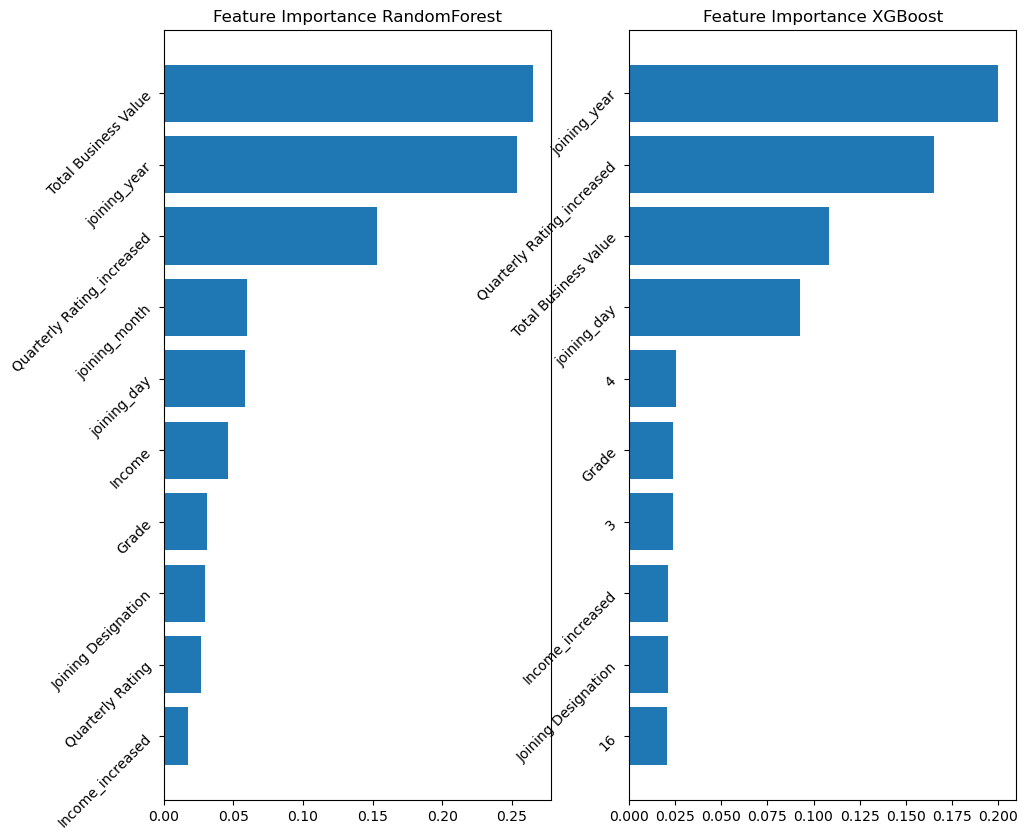

In [126]:
show_importance()

- 'joining_year', 'Total Business values' and 'Quaterly Rating_increased' was reported as top three features by both the models.


<b>Lets first look the realation between top features before going to suggestions.

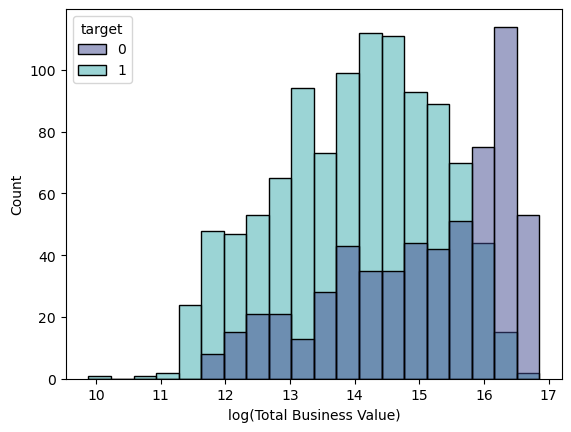

In [149]:
sns.histplot(x=np.log(final_df['Total Business Value']), hue=final_df['target'], palette='mako')
plt.xlabel('log(Total Business Value)')
plt.show()

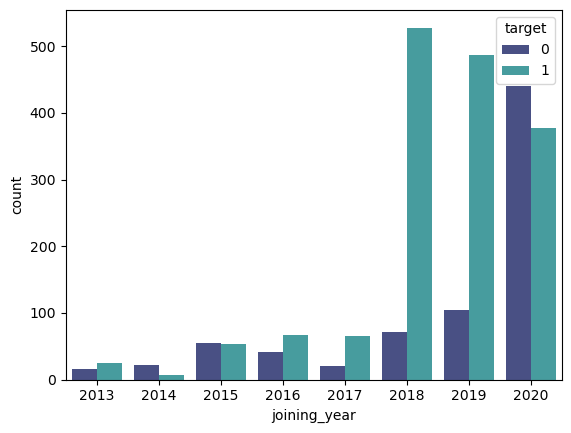

In [151]:
sns.countplot(data=final_df, x='joining_year', hue='target', palette='mako')
plt.show()

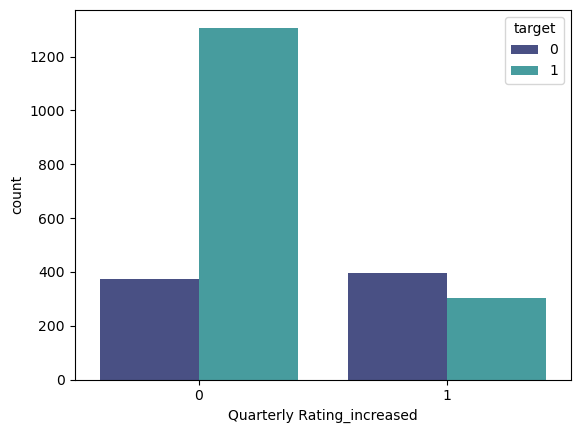

In [153]:
sns.countplot(data=final_df, x='Quarterly Rating_increased', hue='target', palette='mako')
plt.show()

# - Suggesion

- From 'Total Business Value' and 'target' plot, it is pretty clear that the drivers who have collected greater revenue tend to stay at the company. So, Ola must have some system which can suggest the driver to inprove thier revenue. This can be done by means of technology or trainig the drivers.
- From 'joining_year'and 'target' plot, It is clear that most of the drivers who left were from the recent year i.e. between the year 2018 to 2020. There must have been some bad business done by ola cause of which the drivers must have left. The drivers who joined in previous years tend to be loyal to the company. This loyal drivers must be gifted so that newer drivers get motivated to stay longer.
- From 'Quarterly Rating_increased' and 'target' plot, the drivers who could not inprove thier ratings left the company. This situation must be correlated to the first point and the solution is the same that ola has to come up with a system to aid the drivers to increase thier revene by means of technoloy or training them.